In [33]:
# Import Required Libraries
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [34]:
# Set Dataset Paths
dataset_root_path = 'data/idd20k_lite'

gt_train_path = os.path.join(dataset_root_path, 'gtFine/train')
gt_val_path = os.path.join(dataset_root_path, 'gtFine/val')

img_train_path = os.path.join(dataset_root_path, 'leftImg8bit/train')
img_val_path = os.path.join(dataset_root_path, 'leftImg8bit/val')
img_test_path = os.path.join(dataset_root_path, 'leftImg8bit/test')

print(f'Number of training images: {len(os.listdir(img_train_path))}')
print(f'Number of validation images: {len(os.listdir(img_val_path))}')
print(f'Number of test images: {len(os.listdir(img_test_path))}')

Number of training images: 310
Number of validation images: 62
Number of test images: 100


## Utility Functions

In [35]:
# Overlay Ground Truth on Image
def overlay_ground_truth(image, label, alpha=0.5):
    """
    Overlay the ground truth label on the image with transparency.
    
    Args:
        image (np.array): The original image.
        label (np.array): The ground truth label.
        alpha (float): Transparency factor for the overlay.
    
    Returns:
        np.array: The image with the ground truth overlay.
    """
    # Define a color map for the labels
    color_map = {
        255: [0, 0, 0],     # Class 255 (ignore label)
        0: [255, 0, 0],     # Class 0
        2: [0, 255, 0],     # Class 2
        3: [0, 0, 255],     # Class 3
        4: [255, 255, 0],   # Class 4
        5: [0, 255, 255],   # Class 5
        6: [255, 0, 255],   # Class 6
    }
    
    # Create a blank RGB image for the label
    label_color = np.zeros_like(image)

    # Map each unique label to its corresponding color
    for label_value, color in color_map.items():
        label_color[label == label_value] = color

    # Overlay the label on the image
    overlay = cv2.addWeighted(image, 1 - alpha, label_color, alpha, 0)
    return overlay

## Dataset Exploration

In [22]:
# Load Image and Ground Truth
data_dir_name = '0'
img_code = '024541'

img_path = os.path.join(img_train_path, f'{data_dir_name}/{img_code}_image.jpg')
label_path = os.path.join(gt_train_path, f'{data_dir_name}/{img_code}_label.png')
inst_label_path = os.path.join(gt_train_path, f'{data_dir_name}/{img_code}_inst_label.png')

img = cv2.imread(img_path)
label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Load label as grayscale
inst_label = cv2.imread(inst_label_path, cv2.IMREAD_GRAYSCALE)  # Load instance label as grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

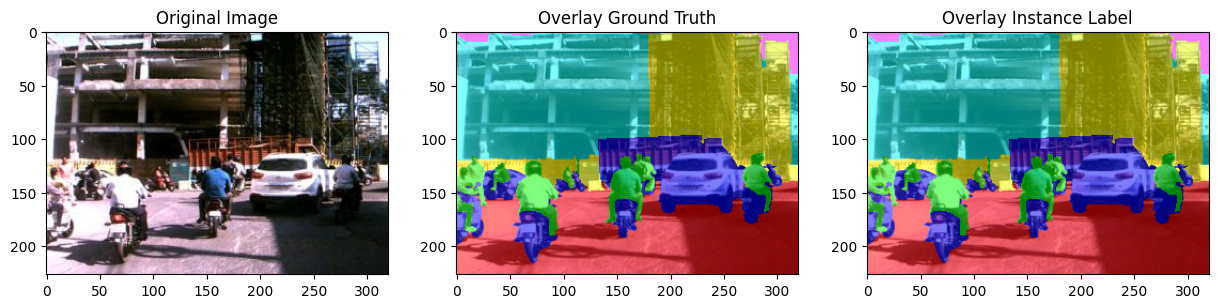

In [5]:
# Visualize with Different Colors
overlay_label = overlay_ground_truth(img, label)
overlay_inst_label = overlay_ground_truth(img, inst_label)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(overlay_label)
plt.title('Overlay Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(overlay_inst_label, cmap='gray')
plt.title('Overlay Instance Label')
plt.show()

## DeepLab Trial

In [36]:
# Load Image and Ground Truth
data_dir_name = '0'
img_code = '024541'

img_path = os.path.join(img_train_path, f'{data_dir_name}/{img_code}_image.jpg')
label_path = os.path.join(gt_train_path, f'{data_dir_name}/{img_code}_label.png')

img = Image.open(img_path)
img = img.convert('RGB')  # Convert to RGB
label = Image.open(label_path)
label = label.convert('L')  # Convert to grayscale

In [37]:
deeplab_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# deeplab_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# deeplab_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)

deeplab_model.eval()

Using cache found in /Users/abinashchetia/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/abinashchetia/Desktop/IIITH_assignment/idd-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/abinashchetia/Desktop/IIITH_assignment/idd-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [38]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.backends.mps.is_available():
    input_batch = input_batch.to('mps')
    deeplab_model.to('mps')

with torch.no_grad():
    output = deeplab_model(input_batch)['out'][0]
output_predictions = output.argmax(0)

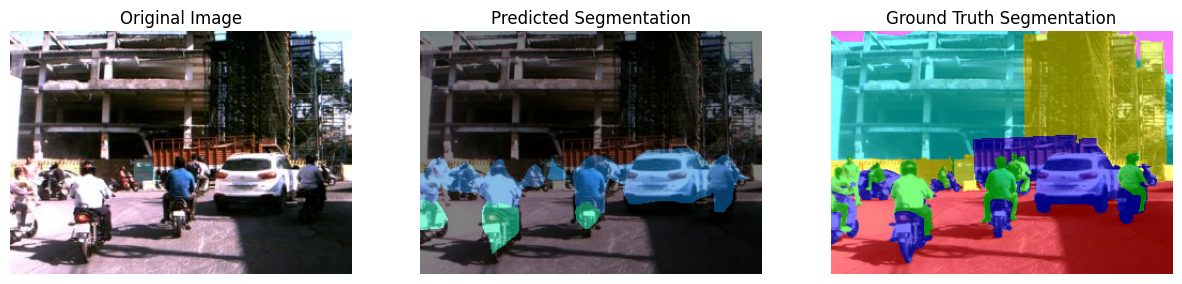

In [39]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# overlay the segmentation on the image
r = Image.fromarray(colors[output_predictions.byte().cpu().numpy()])
r.putalpha(128)  # Set transparency for the overlay
img_a = img.convert('RGBA')
r = Image.alpha_composite(img_a, r)
r = r.convert('RGB')  # Convert back to RGB for display

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(r)
plt.subplot(1, 3, 3)
plt.title('Ground Truth Segmentation')
plt.axis('off')
plt.imshow(overlay_ground_truth(np.array(img), np.array(label)))
plt.show()